## LGBM regression on IE dataset
### Using functional group features & cross validation 

**Created on 29th August, 2022; modified on 7th September; remodified on 4th January, 2023**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
# from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna ## hyperparameter optimization
import lightgbm as lgb
from lightgbm import LGBMRegressor
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/redox-stability/lgbm_01-04-23
total 13976
-rw-r--r--   1 riteshkumar  staff        0 Jan  4 18:06 more-rdkit-features-used
drwxr-xr-x  14 riteshkumar  staff      448 Jan  4 18:17 feat-gen
-rw-r--r--   1 riteshkumar  staff   497131 Jan  4 18:17 test_fgrp_feat.csv
-rw-r--r--   1 riteshkumar  staff  3960002 Jan  4 18:17 train_fgrp_feat.csv
-rw-r--r--   1 riteshkumar  staff   495572 Jan  4 18:17 val_fgrp_feat.csv
-rw-r--r--@  1 riteshkumar  staff   917505 Jan  4 18:17 final_MP_red4.csv
-rw-r--r--@  1 riteshkumar  staff  1277748 Jan  4 18:18 lgbm_random_ie.ipynb


In [3]:
df = pd.read_csv('final_MP_red4.csv')
df

,smiles,IE,EA
0,C(C#CC(C)C)(C)C,5.481535,-0.771096
1,C(=O)=O,9.433272,0.941193
2,O,7.902121,-1.343401
3,C(=C\C)/C(C)C,5.085723,-1.005246
4,c1(c(ccc(c1)C)C)C,4.733493,-0.843508
...,...,...,...
18128,c1cc(c2c(c1)[nH]sn2N(=O)=O)C(=O)O,3.220508,3.856206
18129,CC(=O)c1ccc2c(c1C#N)[nH]s[nH]2,3.620069,1.502602
18130,CCn1c2ccc(cc2[nH]s1)Cl,3.308856,2.027702
18131,CCc1ccc2c(c1O)[nH]s[nH]2,3.476727,2.415027


Read the train, validation, and test sets

In [4]:
val_df = pd.read_csv('val_fgrp_feat.csv')
# val_df.to_csv('val_single_all_rdkit_features.csv', index=False)
val_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,CN1C[C@H](N(C)C[C@H]1N)N(=O)=O,0,0,0,0,0,0,0,0,0,...,-1.24880,44.0178,75.64,1.000000,-0.72,71.070664,70,0.280466,-0.314653,4.481108
1,C1=C[C@H](C(=C1)N)N,0,0,0,0,0,0,0,0,0,...,-0.27390,29.3858,52.04,0.200000,-0.76,42.493764,38,0.063096,-0.400495,3.293469
2,CCc1cnc(CC)cn1,0,0,0,0,0,0,0,0,0,...,1.60140,40.7880,25.78,0.500000,-0.92,61.330468,54,0.058368,-0.257810,5.273551
3,Cc1cc2c(cc1/N=C(/C)\O)ONO2,0,0,0,0,0,0,0,0,0,...,1.79372,50.9685,63.08,0.222222,-1.75,80.894984,74,0.197611,-0.496538,3.960204
4,C#Cc1c(C=C)nccn1,0,0,0,0,0,0,0,0,0,...,1.10090,40.0580,25.78,0.000000,-1.62,59.640090,48,0.138054,-0.252326,5.201518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,CC(C)(C)c1cc(c2c(c1)ONO2)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,3.19370,54.5357,30.49,0.454545,-1.43,96.431918,94,0.419721,-0.369584,4.573617
1810,C/C(=N/c1ccsc1F)/O,0,0,0,0,0,0,0,0,0,...,2.49510,39.6748,32.59,0.166667,-0.90,61.656742,54,0.201737,-0.496537,4.353451
1811,C=Cc1ccc(N(C)C)s1,0,0,0,0,0,0,0,0,0,...,2.45710,48.7370,3.24,0.250000,-0.76,65.601765,54,0.090903,-0.369563,3.324745
1812,CCc1ccc2c(c1)ON(N)O2,0,0,0,0,0,0,0,0,0,...,1.02590,43.1024,47.72,0.250000,-1.26,70.360484,64,0.197614,-0.353755,3.235921


In [5]:
test_df = pd.read_csv('test_fgrp_feat.csv')
test_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,CCc1c(ccc2c1ONO2)OC,0,0,0,0,0,0,0,0,0,...,1.44840,46.7637,39.72,0.333333,-1.42,76.318973,70,0.202300,-0.496327,4.100620
1,O=COC[C@@H](C=O)C#N,0,0,0,0,0,0,0,0,1,...,-0.50192,27.1830,67.16,0.400000,-1.37,52.028189,48,0.292634,-0.466029,8.128354
2,C1[C@H]([C@H](CSC1)CC)CC,1,0,0,0,0,0,0,0,0,...,3.17570,49.5040,0.00,1.000000,0.35,68.776067,60,-0.003658,-0.161697,4.574026
3,C(=O)(N(O)c1ccccc1)c1ccccc1,0,0,0,0,0,0,0,0,0,...,2.72260,61.4800,40.54,0.000000,-2.13,93.523067,80,0.281484,-0.280662,4.600431
4,C[C@@]12[C@H]3N4[C@@H]1[C@]2(C)[C@@]34C,0,0,0,0,0,0,0,0,0,...,0.85130,34.0340,3.01,1.000000,-0.04,55.030355,48,0.042502,-0.286071,5.203414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,C(O)c1ccc(cc1)Cl,0,0,0,0,1,0,0,0,0,...,1.83230,37.3748,20.23,0.142857,-0.53,58.893845,48,0.068139,-0.391680,5.163176
1810,CCC1=COC=C(C#N)O1,0,0,0,0,0,0,0,0,0,...,1.64958,34.2400,42.25,0.285714,-1.43,59.163537,52,0.238068,-0.464407,4.477547
1811,C1CO[C@](C#N)(CO1)O,0,0,0,0,0,0,0,0,0,...,-0.75462,27.3338,62.48,0.800000,-0.63,52.607092,50,0.280664,-0.372224,6.066940
1812,CC(C)(C)c1ccc2c(c1)[nH]sn2N(=O)=O,0,0,0,0,0,0,0,0,0,...,2.97090,65.8291,58.41,0.400000,-1.43,98.212013,86,0.177580,-0.305088,4.017905


In [6]:
train_df = pd.read_csv('train_fgrp_feat.csv')
train_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,COCCOc1cscc1OC,0,0,0,0,0,0,0,0,0,...,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993,4.306098
1,c1c(c2c(cc1)nccn2)C(=O)O,0,0,0,0,0,0,0,0,0,...,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581,5.330098
2,C=Cc1cccc2c1[nH]sn2OCCOC,0,0,0,0,0,0,0,0,0,...,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191,3.957699
3,c1ccc(cc1)C1(CCCC1)O,0,0,0,0,0,0,0,0,0,...,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172,5.178552
4,C(#N)C1=COC(=CO1)N,0,0,0,0,0,0,0,0,0,...,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,CC(C)(C)c1cc(C#N)c2c(c1)ONO2,0,0,0,0,0,0,0,0,0,...,2.04658,54.2487,54.28,0.363636,-1.73,88.327892,78,0.213150,-0.369549,4.638594
14501,C=Cc1cscc1F,0,0,0,0,0,0,0,0,0,...,2.53020,34.3680,0.00,0.000000,-0.63,51.277583,42,0.140567,-0.205425,4.756748
14502,n1c(cncc1C)C,0,0,0,0,0,0,0,0,0,...,1.09344,31.5060,25.78,0.333333,-0.92,48.600583,42,0.055846,-0.260951,5.327466
14503,c1ccc(cc1)[C@@H]1[C@H](C(=O)O)SCCS1,2,0,0,0,0,0,0,0,0,...,2.66090,65.5228,37.30,0.363636,-0.61,97.452258,80,0.317615,-0.480376,4.915535


In [7]:
X_train = train_df.iloc[:,1:-1]
y_train = train_df.iloc[:,-1]
X_train

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,mol_sssr,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge
0,0,0,0,0,0,0,0,0,0,3,...,1,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993
1,0,0,0,0,0,0,0,0,0,0,...,2,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581
2,0,0,0,0,0,0,0,0,0,1,...,2,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191
3,0,0,0,0,0,0,0,0,0,1,...,2,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172
4,0,0,0,0,0,0,0,0,0,0,...,1,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,0,0,0,0,0,0,0,0,0,0,...,2,2.04658,54.2487,54.28,0.363636,-1.73,88.327892,78,0.213150,-0.369549
14501,0,0,0,0,0,0,0,0,0,0,...,1,2.53020,34.3680,0.00,0.000000,-0.63,51.277583,42,0.140567,-0.205425
14502,0,0,0,0,0,0,0,0,0,0,...,1,1.09344,31.5060,25.78,0.333333,-0.92,48.600583,42,0.055846,-0.260951
14503,2,0,0,0,0,0,0,0,0,0,...,2,2.66090,65.5228,37.30,0.363636,-0.61,97.452258,80,0.317615,-0.480376


In [8]:
X_test = test_df.iloc[:,1:-1]
y_test = test_df.iloc[:,-1]
X_test

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,mol_sssr,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge
0,0,0,0,0,0,0,0,0,0,1,...,2,1.44840,46.7637,39.72,0.333333,-1.42,76.318973,70,0.202300,-0.496327
1,0,0,0,0,0,0,0,0,1,0,...,0,-0.50192,27.1830,67.16,0.400000,-1.37,52.028189,48,0.292634,-0.466029
2,1,0,0,0,0,0,0,0,0,0,...,1,3.17570,49.5040,0.00,1.000000,0.35,68.776067,60,-0.003658,-0.161697
3,0,0,0,0,0,0,0,0,0,0,...,2,2.72260,61.4800,40.54,0.000000,-2.13,93.523067,80,0.281484,-0.280662
4,0,0,0,0,0,0,0,0,0,0,...,5,0.85130,34.0340,3.01,1.000000,-0.04,55.030355,48,0.042502,-0.286071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,0,0,0,0,1,0,0,0,0,1,...,1,1.83230,37.3748,20.23,0.142857,-0.53,58.893845,48,0.068139,-0.391680
1810,0,0,0,0,0,0,0,0,0,0,...,1,1.64958,34.2400,42.25,0.285714,-1.43,59.163537,52,0.238068,-0.464407
1811,0,0,0,0,0,0,0,0,0,1,...,1,-0.75462,27.3338,62.48,0.800000,-0.63,52.607092,50,0.280664,-0.372224
1812,0,0,0,0,0,0,0,0,0,0,...,2,2.97090,65.8291,58.41,0.400000,-1.43,98.212013,86,0.177580,-0.305088


In [9]:
X_val = val_df.iloc[:,1:-1]
y_val = val_df.iloc[:,-1]
X_val

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,mol_sssr,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge
0,0,0,0,0,0,0,0,0,0,0,...,1,-1.24880,44.0178,75.64,1.000000,-0.72,71.070664,70,0.280466,-0.314653
1,0,0,0,0,0,0,0,0,0,0,...,1,-0.27390,29.3858,52.04,0.200000,-0.76,42.493764,38,0.063096,-0.400495
2,0,0,0,0,0,0,0,0,0,0,...,1,1.60140,40.7880,25.78,0.500000,-0.92,61.330468,54,0.058368,-0.257810
3,0,0,0,0,0,0,0,0,0,0,...,2,1.79372,50.9685,63.08,0.222222,-1.75,80.894984,74,0.197611,-0.496538
4,0,0,0,0,0,0,0,0,0,0,...,1,1.10090,40.0580,25.78,0.000000,-1.62,59.640090,48,0.138054,-0.252326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,0,0,0,0,0,0,0,0,0,0,...,2,3.19370,54.5357,30.49,0.454545,-1.43,96.431918,94,0.419721,-0.369584
1810,0,0,0,0,0,0,0,0,0,0,...,1,2.49510,39.6748,32.59,0.166667,-0.90,61.656742,54,0.201737,-0.496537
1811,0,0,0,0,0,0,0,0,0,0,...,1,2.45710,48.7370,3.24,0.250000,-0.76,65.601765,54,0.090903,-0.369563
1812,0,0,0,0,0,0,0,0,0,0,...,2,1.02590,43.1024,47.72,0.250000,-1.26,70.360484,64,0.197614,-0.353755


**Without standardization/scaling**

In [10]:
X_train_ = np.array(X_train)
X_val_ = np.array(X_val)
X_test_ = np.array(X_test)

In [11]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        gbm.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_cv_' + str(10) + '.txt'  ## 10 => max_depth
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [13]:
def read_param(param):
    fname = 'best-paramters_lgbr_cv_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [14]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
# p1 = 0.0005080097584855421
# p2 = 0.00013404290033216872
# p3 = 76
# p4 = 388
# p5 = 4
# p6 = 47
# p7 = 0.13488193271053475
# p8 = 0.552948703797635
# p9 = 9
# p10 = 12
# p11 = 0.14888930767916256
# p12 = 0.2984893583652126
# p13 = 0.8778379420937655
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}

0.02035552022786401 6.162830072459153e-08 93 475 7 43 0.9471171095667777 0.7595189683386141 7 46 0.11991091364514622 0.1296286838983902 0.2782363058410671


In [15]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.2782363058410671, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.2782363058410671
[LightGBM] [Warning] lambda_l1 is set=0.02035552022786401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02035552022786401
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=0.11991091364514622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11991091364514622
[LightGBM] [Warning] feature_fraction is set=0.9471171095667777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9471171095667777
[LightGBM] [Warning] bagging_fraction is set=0.7595189683386141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

In [16]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))

93
Best RMSE for train/val: 0.32028663008880515/0.36068384054361297
Best R2 for train/val: 0.925969596351868/0.9031591302460571


In [17]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [18]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.32028663008880515 / 0.36068384054361297 / 0.3762555169148292
R2 for train / validation / test: 0.925969596351868 / 0.9031591302460571 / 0.8964976131589908


In [18]:
# save_fig_path = '/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/2022-01-24/ionic-conductivity_2.0/lgbm_08-29-22/multi-comp/2D-feat/split-freq-2/'

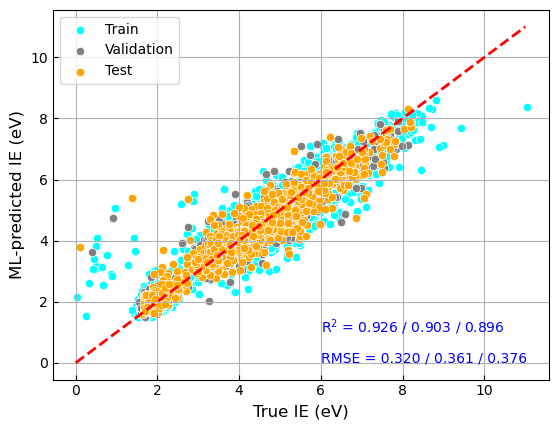

In [19]:
xl = np.arange(0,12,1)
yl = np.arange(0,12,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True IE (eV)',fontsize=12)
plt.ylabel('ML-predicted IE (eV)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(6, 0, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(6, 1, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

**With standardization**

In [20]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

In [21]:
X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [22]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        gbm.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_cvs_' + str(10) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [24]:
def read_param(param):
    fname = 'best-paramters_lgbr_cvs_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [25]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

6.971346599223287e-07 7.459465202275412e-08 75 424 8 45 0.6558799653433162 0.6801244896910404 1 14 0.11692239456300443 0.1237201002660635 0.39484785466801864


In [26]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.39484785466801864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.39484785466801864
[LightGBM] [Warning] lambda_l1 is set=6.971346599223287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.971346599223287e-07
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=0.11692239456300443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11692239456300443
[LightGBM] [Warning] feature_fraction is set=0.6558799653433162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6558799653433162
[LightGBM] [Warning] bagging_fraction is set=0.6801244896910404, subsample=1.0 will be ignored. Current value: bagging_fract

In [27]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

42
Best RMSE for train/val: 0.27449785838299157/0.33698668639312784
Best R2 for train/val: 0.9456236041873667/0.9154661211841993


In [28]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [29]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.27449785838299157 / 0.33698668639312784 / 0.3606633573309728
R2 for train / validation / test: 0.9456236041873667 / 0.9154661211841993 / 0.9048982181300268


In [23]:
# save_fig_path = '/Users/riteshkumar/Library/CloudStorage/Box-Box/Meetings/Subgroup-meetings/liquid-electrolyte/2022-08-10/'
save_fig_path = os.getcwd()

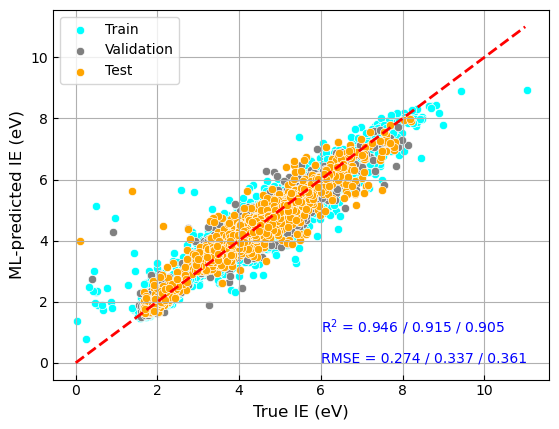

In [30]:
xl = np.arange(0,12,1)
yl = np.arange(0,12,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True IE (eV)',fontsize=12)
plt.ylabel('ML-predicted IE (eV)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(6, 0, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(6, 1, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

In [35]:
# pickle.dump(model[ind], open('lgbm_cond_multi_random_scaled_3.pkl', 'wb')) ## this model used

Run again for saving the model

In [40]:
p1 = 6.971346599223287e-07
p2 = 7.459465202275412e-08
p3 = 75
p4 = 424
p5 = 8
p6 = 45
p7 = 0.6558799653433162
p8 = 0.6801244896910404
p9 = 1
p10 = 14
p11 = 0.11692239456300443
p12 = 0.1237201002660635
p13 = 0.39484785466801864
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}

R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 42
end = 42
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

y_pred_train = model[0].predict(X_train_)
y_pred_val = model[0].predict(X_val_)
y_pred_test = model[0].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[0], rmse_val_array[0], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[0], R2_val_array[0], R2_test))

counter for cv split:  42
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.39484785466801864, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.39484785466801864
[LightGBM] [Warning] lambda_l1 is set=6.971346599223287e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.971346599223287e-07
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=0.11692239456300443, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11692239456300443
[LightGBM] [Warning] feature_fraction is set=0.6558799653433162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6558799653433162
[LightGBM] [Warning] bagging_fraction is set=0.6801244896910404, subsample=1.0 will be ignored. Current value: bagging_frac

In [41]:
pickle.dump(lgb, open('lgbm_ie_random_scaled_2.pkl', 'wb'))

Without CV on validation

In [31]:
def objective(trial):
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    gbm.fit(X_train_, y_train)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_wocv_' + str(10) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [33]:
def read_param(param):
    fname = 'best-paramters_lgbr_wocv_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [34]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
# params = {"objective": 'regression', "metric": "root_mean_squared_error", "linear_trees": True, 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

5.3789382471891965e-06 0.01692440401982355 79 369 8 48 0.8231594662651629 0.6342665455207867 2 17 0.10083877151475326 0.20736220654535367 0.5411781931123412


In [35]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.5411781931123412, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.5411781931123412
[LightGBM] [Warning] lambda_l1 is set=5.3789382471891965e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.3789382471891965e-06
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=0.10083877151475326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10083877151475326
[LightGBM] [Warning] feature_fraction is set=0.8231594662651629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8231594662651629
[LightGBM] [Warning] bagging_fraction is set=0.6342665455207867, subsample=1.0 will be ignored. Current value: bagging_fract

In [36]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

47
Best RMSE for train/val: 0.2730739884206841/0.3373763623512896
Best R2 for train/val: 0.9461862614598039/0.9152705059436996


In [37]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [38]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.2730739884206841 / 0.3373763623512896 / 0.3648374612349966
R2 for train / validation / test: 0.9461862614598039 / 0.9152705059436996 / 0.9026841765422687


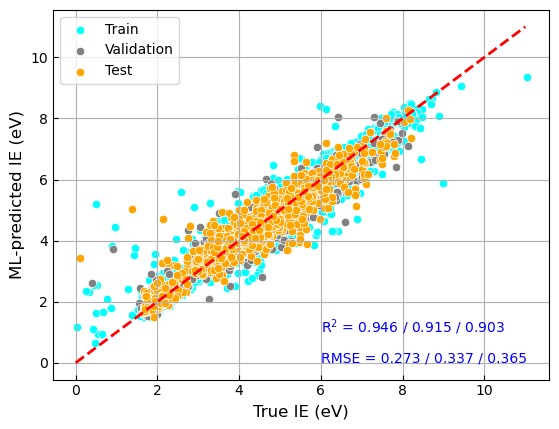

In [39]:
xl = np.arange(0,12,1)
yl = np.arange(0,12,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True IE (eV)',fontsize=12)
plt.ylabel('ML-predicted IE (eV)',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(6, 0, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(6, 1, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

In [47]:
# pickle.dump(model[ind], open('lgbm_cond_multi_random_scaled_32.pkl', 'wb')) ## this model not used